# Prática 7: Experimentos - Parte VII

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

O trabalho desenvolvido nessa atividade prática tem como objetivo realizar uma avaliação do algoritmo de classificação por meio de métricas extraídas da matriz de confusão, curva ROC e teste de hipóteses.

Iremos continuar o trabalho desenvolvido na prática 6, na qual foi utilizado o dataset Breast Cancer.

## Dataset: Breast Cancer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./breast_cancer/wdbc.data',sep=',',header=None,encoding='latin1')

#Extração dos atributos necesssários
breast_cancer = dataset.iloc[:,[5,13,16,1]]

#Renomeando as colunas
breast_cancer.columns = ['area','smoothness','texture','class']

#Mostrando os dados
breast_cancer.head()

,area,smoothness,texture,class
0,1001.0,0.9053,0.006399,M
1,1326.0,0.7339,0.005225,M
2,1203.0,0.7869,0.006150,M
3,386.1,1.1560,0.009110,M
4,1297.0,0.7813,0.011490,M


### 1 - Métrica de avaliação

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target,folds=5):
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    
    # prepara validação cruzada
    cv = KFold(n_splits=folds, shuffle=True)
    
    for train_index, test_index in cv.split(data):
        # separa conjunto de treino e de teste
        x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
        x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
        # faz o treino do modelo
        clf = dt.fit(X=x_train, y=y_train)
            
        # valores predito pelo classificador
        y_pred = clf.predict(x_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
    #retorna os ultimos valores
    return y_pred,y_test

In [4]:
#Classificando novamente para retornar os valores preditos e verdadeiros
y_pred, y_test = classificacao(breast_cancer,[0,1,2], 3,folds=10)

In [5]:
from sklearn.metrics import confusion_matrix

#Criando a matriz de confusão
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculos e print's
rev = tp/(tp+fn)
prec = tp/(tp+fp)
print('Acurácia: ',(tn+tp)/(tn+fp+fn+tp))
print('Especificidade: ',tn/(tn+fp))
print('Revocação/Sensibilidade: ',rev)
print('Precisão: ',prec)
print('Medida-F1:',2/((1/prec) + (1/rev)))

Acurácia:  0.8392857142857143
Especificidade:  0.8888888888888888
Revocação/Sensibilidade:  0.75
Precisão:  0.7894736842105263
Medida-F1: 0.7692307692307694


TEXTO

### 2 - Curva ROC e AUC

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target,folds=5, model='dt'):

    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    if(model == 'dt'):
        c = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    else:
        c = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    
    #Split em treino (80%) em teste (20%)
    x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,columns],data.iloc[:,target],test_size=0.2)
    
    # faz o treino do modelo
    clf = c.fit(X=x_train, y=y_train)
            
    # valores predito pelo classificador
    y_prob = clf.predict_proba(x_test)
    # rótulos verdadeiros convertidos para array
    y_test = np.array(y_test)
    
    return y_prob,y_test

In [7]:
#Probabilidades da previsao e valor esperado
y_prob_dt, y_test_dt = classificacao(breast_cancer,[0,1,2], 3,folds=10)
y_prob_3nn, y_test_3nn = classificacao(breast_cancer,[0,1,2], 3,folds=10,model='3nn')

In [8]:
#Binarizando
def to_bin(x):
    if(x == 'M'):
        return 1
    else:
        return 0

y_test_dt = list(map(to_bin,y_test_dt))
y_test_3nn = list(map(to_bin,y_test_3nn))

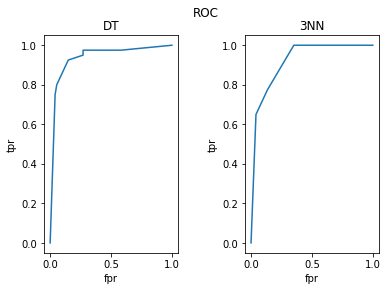

In [9]:
from sklearn.metrics import roc_curve

#Curva ROC
plt.subplots_adjust(wspace=0.5)
plt.suptitle('ROC')

#ROC - DT
fpr, tpr, thresholds = roc_curve(y_test_dt,y_prob_dt[:,1])
ax = plt.subplot(121)
ax.set_title('DT')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.plot(fpr,tpr)

#ROC - 3NN
fpr, tpr, thresholds = roc_curve(y_test_3nn,y_prob_3nn[:,1])
ax = plt.subplot(122)
ax.set_title('3NN')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.plot(fpr,tpr)
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score

#Medida AUC
print('AUC DT: ',roc_auc_score(y_test_dt,y_prob_dt[:,1]))
print('AUC 3NN:',roc_auc_score(y_test_3nn,y_prob_3nn[:,1]))

AUC DT:  0.9380067567567567
AUC 3NN: 0.9211148648648649


### 3 - Desempenho dos classificadores

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target,score,folds=5, model='dt'):

    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    if(model == 'dt'):
        c = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    else:
        c = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    
    # prepara validação cruzada
    cv = KFold(n_splits=folds, shuffle=True)
    
    results = []
    for train_index, test_index in cv.split(data):
        # separa conjunto de treino e de teste
        x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
        x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
        # faz o treino do modelo
        clf = c.fit(X=x_train, y=y_train)
            
        # valores predito pelo classificador
        y_pred = clf.predict(x_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
        # realiza predição no conjunto de teste e salva o resultado
        results.append( score(y_test, y_pred) )
        
    return results

In [12]:
#Definindo função que penaliza a taxa de falso positivo
def pen_falso_positivo(y_true, y_pred):
    count = 0
    for i,j in enumerate(y_pred):
        if y_true[i] == 'B' and j == 'M':
            count += 2
        elif y_true[i] == 'M' and j == 'B':
            count += 1
    return count/len(y_true)

In [13]:
from scipy import stats
from scipy.stats import ttest_ind
np.random.seed(12345678)

# 10-fold Cross Validation
clf_custom_cross_validation_dt = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo,folds=10)
clf_custom_cross_validation_3nn = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo,folds=10,model='3nn')
print(ttest_ind(clf_custom_cross_validation_dt,clf_custom_cross_validation_3nn))

Ttest_indResult(statistic=-1.3717275217004035, pvalue=0.18700543442335377)
